In [1]:
# load dependencies
import os
import matplotlib.pyplot as plt
import pystac_client
from odc.stac import stac_load
import xarray as xr
import rioxarray as rxr

In [2]:
# set data and output dir
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [3]:
# define location
latitude = 27.163
longitude = 82.608
year = 2023

In [4]:
# query sentinel
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}},
)
items = search.item_collection()

In [14]:
# load as xarray dataset
import sys

ds = stac_load(
    items,
    bands=['red', 'green', 'blue', 'nir'],
    resolution=10,
    bbox=bbox,
    chunks={},  # <-- use Dask
    groupby='solar_day',
)
ds

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

In [15]:
%%time
ds = ds.compute()
ds


CPU times: user 4.96 s, sys: 1.34 s, total: 6.3 s
Wall time: 30.5 s


<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB 7592 7548 7388 7236 ... 2038 2198 2240
    green        (time, y, x) uint16 5MB 7308 7260 7188 7064 ... 2204 2192 2188
    blue         (time, y, x) uint16 5MB 7332 7152 7112 7036 ... 1947 2010 2040
    nir          (time, y, x) uint16 5MB 8076 7996 7840 7708 ... 3978 3708 3352

In [16]:
# aggregate to monthly composites
monthly = ds.groupby('time.month').median(dim='time')
monthly

<xarray.Dataset> Size: 14MB
Dimensions:      (month: 12, y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 4MB 1.786e+03 1.72e+03 ... 2.225e+03
    green        (month, y, x) float64 4MB 2.006e+03 1.976e+03 ... 2.191e+03
    blue         (month, y, x) float64 4MB 1.842e+03 1.802e+03 ... 2.016e+03
    nir          (month, y, x) float64 4MB 3.754e+03 3.972e+03 ... 3.232e+03

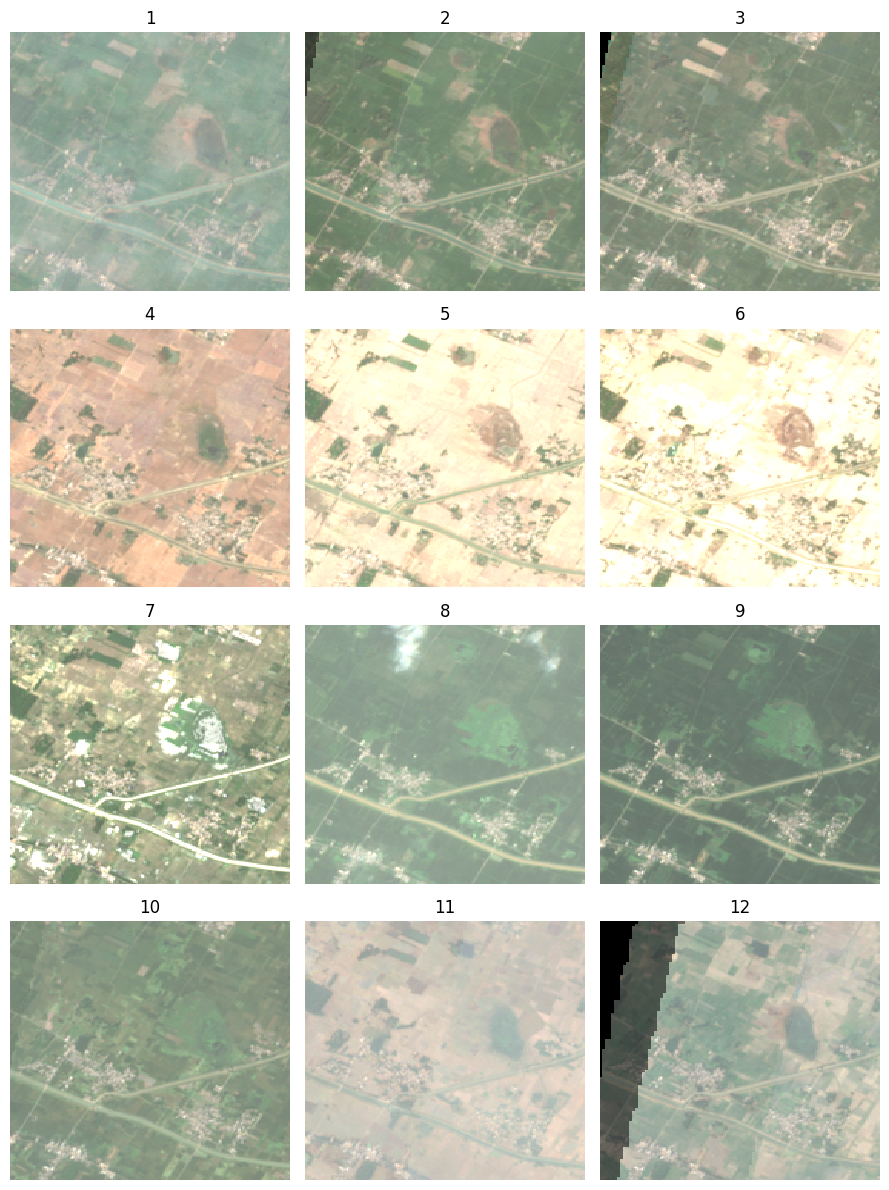

In [17]:
# display all months true color
monthly_da = monthly.to_array('band')
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(9, 12)
for index, ax in enumerate(axes.flat):
    month_da = monthly_da.isel(month=index)
    month_da.sel(band=['red', 'green', 'blue']).plot.imshow(
      ax=ax,
      vmin=0,
      vmax=3000)
    ax.set_title(f'{month_da.month.values}')
    ax.set_axis_off()
plt.tight_layout()
plt.show()